In [128]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from collections import  defaultdict
conn = sqlite3.connect('data/DailyReports (2).db')

In [129]:
df_service_popularity = pd.read_sql_query("""select service, count(*) as 'performed'
                                 from orderservices group by service order by COUNT(*) DESC;""", conn)

In [130]:
#  .head(#) will select the first '#' from the top
df_service_popularity.head(5)

,service,performed
0,diag,87
1,software repair,57
2,software install,55
3,data backup,36
4,password reset,14


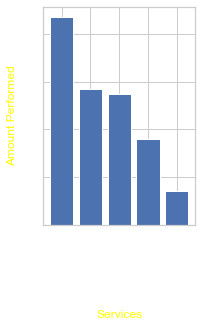

In [131]:
fig = plt.figure()
ax = fig.add_subplot(121)

# Using top 5 Services and their Amount as our X and Y
plt.bar(df_service_popularity['service'].head(5), df_service_popularity['performed'].head(5))

# Set X and Y Labels
ax.set_xlabel('Services')
ax.set_ylabel('Amount Performed')

# Changing color of Axes Labels
ax.xaxis.label.set_color('yellow')
ax.yaxis.label.set_color('yellow')

# Rotate the x-axis labels and change color of axes
plt.xticks(rotation=65)
ax.tick_params(axis='x', colors='White')
ax.tick_params(axis='y', colors='White')

In [132]:

# 2. performing Affinity analysis on a group of data from the events database
##   I'm using pandas as "pd" to load data into a data frame

df_affinity_analysis = pd.read_sql_query("""select s1.order_id, s1.service as service1, s2.service as service2
                        from orderservices s1
                        JOIN orderservices s2
                        ON s1.order_id = s2.order_id AND
                        s1.service != s2.service
                        GROUP BY s1.order_id, s1.service, s2.service
                        HAVING s2.service != "";""", conn)

                         # ( Having s2.service != "" ) is necessary because some services occur
                         # only once therefore the "s1.service != s2.service" will cause s2.service
                         # to equal "".


In [133]:
# Display the dataframe
df_affinity_analysis

,order_id,service1,service2
0,22233988,data backup,diag
1,22233988,data backup,software install
2,22233988,data backup,software repair
3,22233988,diag,data backup
4,22233988,diag,software install
...,...,...,...
545,2225136731,software repair,data backup
546,2225136731,software repair,diag
547,2225136731,software repair,software install
548,2225137759,data backup,diag


In [134]:
#Total amount of services performed with another service (unreduced)
# df_affinity_analysis.shape[0]


# Getting rid of double results (reduced)
reduced_row_count = df_affinity_analysis.shape[0] // 2
print(reduced_row_count)



275


In [135]:
unique_services = pd.unique(df_affinity_analysis['service1'])
# n_services = len(unique_services)
# print(unique_services)

In [136]:
groups = Counter()
for row in df_affinity_analysis[['service1', 'service2']].values:
    # "+= .5" is used to prevent counting double results
    groups[frozenset([row[0], row[1]])] += .5

# My attempt at trying to use iterrows() so I don't have to use a frozenset
# for i , j in df_affinity_analysis.iterrows():
#     print(f" {j[1]}...... {j[2]} ")
#     dict = pd.unique(list[j[1]])


In [137]:
# Display groups Counter
groups


Counter({frozenset({'data backup', 'diag'}): 31.0,
         frozenset({'data backup', 'software install'}): 28.0,
         frozenset({'data backup', 'software repair'}): 29.0,
         frozenset({'diag', 'software install'}): 55.0,
         frozenset({'diag', 'software repair'}): 57.0,
         frozenset({'software install', 'software repair'}): 52.0,
         frozenset({'diag', 'password reset'}): 12.0,
         frozenset({'password reset', 'software install'}): 4.0,
         frozenset({'password reset', 'software repair'}): 3.0,
         frozenset({'diag', 'software installation'}): 1.0,
         frozenset({'password reset', 'software installation'}): 1.0,
         frozenset({'diag', 'hardware repair'}): 1.0,
         frozenset({'data backup', 'password reset'}): 1.0})

In [139]:
service1_service2_amount = []
total_pairs = 0

for k in groups:
    print(f" Service 1 '{list(k)[0]}' and Service 2 '{list(k)[1]}' occur together {groups[k]} times.")
    service1_service2_amount.append((list(k)[0], list(k)[1], groups[k]))
    total_pairs += groups[k]

In [ ]:
services = {", ".join(list(k)): groups[k] for k in groups.keys()}
print(services)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'data backup, diag'),
  Text(1, 0, 'data backup, software install'),
  Text(2, 0, 'data backup, software repair'),
  Text(3, 0, 'software install, diag'),
  Text(4, 0, 'software repair, diag'),
  Text(5, 0, 'software install, software repair'),
  Text(6, 0, 'password reset, diag'),
  Text(7, 0, 'password reset, software install'),
  Text(8, 0, 'password reset, software repair'),
  Text(9, 0, 'diag, software installation'),
  Text(10, 0, 'password reset, software installation'),
  Text(11, 0, 'hardware repair, diag'),
  Text(12, 0, 'data backup, password reset')])

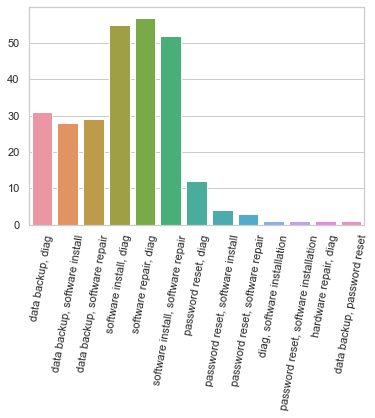

In [144]:
#Using Seaborn to plot data

# Set style of bar plot
sns.set_theme(style='whitegrid')

# Plot Service Pairs (X-axis) and their Appeared Amount (Y-Axis)
ax = sns.barplot(x=list(services.keys()), y=list(services.values()))
plt.xticks(rotation=80)
# plt.tight_layout()


#%

In [163]:
# Print Confidence Rate of the Service Pairs

for x in service1_service2_amount:
    print(f" {x[0].upper()} with {x[1].upper()} has a {round((x[2]/total_pairs)*100,2)}% confidence rate")


 DATA BACKUP with DIAG has a 11.27% confidence rate
 DATA BACKUP with PASSWORD RESET has a 0.36% confidence rate
 DATA BACKUP with SOFTWARE INSTALL has a 10.18% confidence rate
 DATA BACKUP with SOFTWARE REPAIR has a 10.55% confidence rate
 DIAG with SOFTWARE INSTALLATION has a 0.36% confidence rate
 HARDWARE REPAIR with DIAG has a 0.36% confidence rate
 PASSWORD RESET with DIAG has a 4.36% confidence rate
 PASSWORD RESET with SOFTWARE INSTALL has a 1.45% confidence rate
 PASSWORD RESET with SOFTWARE INSTALLATION has a 0.36% confidence rate
 PASSWORD RESET with SOFTWARE REPAIR has a 1.09% confidence rate
 SOFTWARE INSTALL with DIAG has a 20.0% confidence rate
 SOFTWARE INSTALL with SOFTWARE REPAIR has a 18.91% confidence rate
 SOFTWARE REPAIR with DIAG has a 20.73% confidence rate
[('data backup', 'diag', 31.0), ('data backup', 'password reset', 1.0), ('data backup', 'software install', 28.0), ('data backup', 'software repair', 29.0), ('diag', 'software installation', 1.0), ('hardware 